In [1]:
import os
import sys
import time
import json
from datetime import datetime

import numpy as np
import pandas as pd

from models import models
from utils import read_df, read_numpy, write_df
import logging

from evaluate import rps

INFO: Pandarallel will run on 50 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 50 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 50 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
#Model imports
import numpy as np
import json
import os
import pandas as pd

from tqdm.auto import tqdm
from multiprocessing import Pool
from iteround import saferound
import scipy.stats as st
import tweedie
from category_encoders import OrdinalEncoder
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=50)

from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

from model import Model
from utils import read_df

INFO: Pandarallel will run on 50 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
DATASET_PATH = './dataset/processed/train_v1'
TEST_DATA_FILENAME = 'test_data.csv'
GROUND_TRUTH_FILENAME = 'test_ground_truth.npy'
TRAIN_DATA_FILENAME = 'train_data.parquet'
TRAIN_DATA_PROCESSED_FILENAME = 'train_data_features.parquet'
ITEM_DATA_FILEPATH = './dataset/items_static_metadata_full.jl'

TRAIN_DATA_X_FILENAME = 'train_data_x.parquet'
TRAIN_DATA_Y_FILENAME = 'train_data_y.parquet'
TRAIN_DATA_X_PROCESSED_FILENAME = 'train_data_x_features.parquet'
TRAIN_DATA_Y_PROCESSED_FILENAME = 'train_data_y_features.parquet'

TEST_FROMTRAIN_DATA_LAST29_FILENAME = 'test_fromtrain_data_last29.parquet'
TEST_FROMTRAIN_DATA_LAST29_PROCESSED_FILENAME = 'test_fromtrain_data_last29_features.parquet'

TRAIN_DATA_X_PROCESSED_TSFRESH_FILENAME = 'train_data_x_features_tsfresh.parquet'
TEST_FROMTRAIN_DATA_LAST29_PROCESSED_TSFRESH_FILENAME = 'test_fromtrain_data_last29_features_tsfresh.parquet'

In [4]:
dateset_indexes = [0]
model_name = 'simple_first_30_days_fixed_spike'

In [5]:
dataset_index = dateset_indexes[0]
dataset_current_path = os.path.join(DATASET_PATH, str(dataset_index))

test_data_filepath = os.path.join(dataset_current_path, TEST_DATA_FILENAME)
ground_truth_filepath = os.path.join(dataset_current_path, GROUND_TRUTH_FILENAME)
train_data_filepath = os.path.join(dataset_current_path, TRAIN_DATA_FILENAME)
train_data_processed_filepath = os.path.join(dataset_current_path, TRAIN_DATA_PROCESSED_FILENAME)

train_data_x_filepath = os.path.join(dataset_current_path, TRAIN_DATA_X_FILENAME)
train_data_y_filepath = os.path.join(dataset_current_path, TRAIN_DATA_Y_FILENAME)
train_data_x_processed_filepath = os.path.join(dataset_current_path, TRAIN_DATA_X_PROCESSED_FILENAME)
train_data_y_processed_filepath = os.path.join(dataset_current_path, TRAIN_DATA_Y_PROCESSED_FILENAME)

test_fromtrain_data_last29_filepath = os.path.join(dataset_current_path, TEST_FROMTRAIN_DATA_LAST29_FILENAME)
test_fromtrain_data_last29_processed_filepath = os.path.join(dataset_current_path, TEST_FROMTRAIN_DATA_LAST29_PROCESSED_FILENAME)

train_data_x_processed_tsfresh_filepath = os.path.join(dataset_current_path, TRAIN_DATA_X_PROCESSED_TSFRESH_FILENAME)
test_fromtrain_data_last29_processed_tsfresh_filepath = os.path.join(dataset_current_path, TEST_FROMTRAIN_DATA_LAST29_PROCESSED_TSFRESH_FILENAME)

In [6]:
#model = models['xgboost_v1']('./dataset')
#model.prepare_data()
#model.train()
#model.predict('./dataset/test_data.csv')

In [7]:
#df_train = read_df(train_data_filepath)
#df_item = read_df(ITEM_DATA_FILEPATH)

In [8]:
df_test = read_df(test_data_filepath)
ground_truth = read_numpy(ground_truth_filepath)

#df_train_processed = read_df(train_data_processed_filepath)

In [9]:
#df_train_x = read_df(train_data_x_filepath)
#df_train_x = read_df(train_data_y_filepath)

#df_test_fromtrain_x_features = read_df(test_fromtrain_data_last29_processed_filepath)
#df_train_x_features = read_df(train_data_x_processed_filepath)
df_train_y_features = read_df(train_data_y_processed_filepath)

In [10]:
df_train_x_features_tsfresh = read_df(train_data_x_processed_tsfresh_filepath)
df_test_fromtrain_x_features_tsfresh = read_df(test_fromtrain_data_last29_processed_tsfresh_filepath)

In [11]:
x_df = df_train_x_features_tsfresh.sample(frac=1, random_state=42).copy()
#x_df = df_test_fromtrain_x_features_tsfresh.sample(frac=1, random_state=42).reset_index(drop=True).copy()

In [12]:
y_df = df_train_y_features.set_index('sku').loc[x_df.index].copy()
#y_df = df_train_y_features.set_index('sku').loc[x_df['sku']].reset_index().copy()

In [58]:
y_sold_quantity_series = np.array(list(y_df['sold_quantity_series'].apply(json.loads).values))
y_cumsum = y_sold_quantity_series.cumsum(axis=1)

SELECT_N = 1

index_list = []
y_ts = []
y_td = []

for i, t in zip(y_df.index, y_cumsum):
    target_stocks, target_dates = np.unique(t, return_index=True)
    if target_stocks[0] == 0:
        target_stocks = target_stocks[1:]
        target_dates = target_dates[1:]
    size = len(target_stocks)
    index = np.arange(size)
    if size > SELECT_N:
        np.random.shuffle(index)
        index = index[:SELECT_N]
    
    for target_stock, target_date in zip(target_stocks[index], target_dates[index]):
        index_list.append(i)
        y_ts.append(target_stock)
        y_td.append(target_date)
        
index_list = np.array(index_list)
y_ts = np.array(y_ts)
y_td = np.array(y_td)

In [14]:
return_mean = np.mean(np.diff(y_sold_quantity_series, axis=1), axis=1)

x_df_filtered_return_mean = select_features(x_df, pd.Series(return_mean, index=y_df.index), n_jobs=96)
x_df_filtered_td = select_features(x_df, pd.Series(y_td, index=y_df.index), n_jobs=96)
x_df_filtered_sum = select_features(x_df, y_df['sold_quantity_sum'], n_jobs=96)
x_df_filtered_mean = select_features(x_df, y_df['sold_quantity_mean'], n_jobs=96)

filtered_dfs = {
    'x_df_filtered_return_mean': x_df_filtered_return_mean,
    'x_df_filtered_td': x_df_filtered_td,
    'x_df_filtered_sum': x_df_filtered_sum,
    'x_df_filtered_mean': x_df_filtered_mean
}

for name in filtered_dfs:
    with open(os.path.join(dataset_current_path,name+'.txt'), 'w', encoding='utf8') as f:
        for column in filtered_dfs[name].columns:
            f.write(column+'/n')

In [19]:
filtered_columns_names = ['x_df_filtered_return_mean', 'x_df_filtered_td', 'x_df_filtered_sum', 'x_df_filtered_mean']
filtered_columns = {}
for name in filtered_columns_names:
    filtered_columns[name] = []
    with open(os.path.join(dataset_current_path,name+'.txt'), 'r', encoding='utf8') as f:
        for column in f:
            filtered_columns[name].append(column[:-1])

In [20]:
similarities = np.zeros((4,4))
for i, name_1 in enumerate(filtered_columns):
    for j, name_2 in enumerate(filtered_columns):
        in_name1_not_in_name2 = set(filtered_columns[name_1]) - set(filtered_columns[name_2])
        in_name2_not_in_name1 = set(filtered_columns[name_2]) - set(filtered_columns[name_1])
        similarities[i][j] = len(in_name1_not_in_name2)
similarities

array([[  0.,  18.,   1.,  45.],
       [ 83.,   0.,   0.,  54.],
       [113.,  47.,   0.,  78.],
       [ 80.,  24.,   1.,   0.]])

In [23]:
all_filtered_columns = []
for name in filtered_columns:
    print(name, len(filtered_columns[name]))
    for column in filtered_columns[name]:
        if column not in all_filtered_columns:
            all_filtered_columns.append(column)
len(all_filtered_columns)

x_df_filtered_return_mean 1116
x_df_filtered_td 1181
x_df_filtered_sum 1228
x_df_filtered_mean 1151


1229

In [24]:
features = all_filtered_columns

In [98]:
with open('dataset/tsfresh_selected_features.txt', 'w', encoding='utf8') as f:
    for column in features:
        f.write(column+'\n')

In [101]:
features = []
with open('dataset/tsfresh_selected_features.txt', 'r', encoding='utf8') as f:
    for column in f:
        features.append(column[:-1])

In [25]:
x_df = x_df[features]

In [26]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

In [27]:
def impute_pool(column):
    return impute(x_df[column].to_frame())

x_df_imputed = []
with Pool(96) as p:
    for data in tqdm(p.imap(impute_pool, x_df.columns), total=len(x_df.columns)):
        x_df_imputed.append(data)
        
x_df = pd.concat(x_df_imputed, axis=1)

  0%|          | 0/1229 [00:00<?, ?it/s]

In [59]:
x_df_filtered = x_df.loc[index_list]

In [60]:
X = np.concatenate((x_df_filtered.values, np.reshape(y_ts, (-1, 1))), axis=1)

In [61]:
y = y_td

In [31]:
x_test_df = df_test_fromtrain_x_features_tsfresh[features].loc[df_test['sku']].copy()

In [32]:
def impute_pool(column):
    return impute(x_test_df[column].to_frame())

x_test_df_imputed = []
with Pool(96) as p:
    for data in tqdm(p.imap(impute_pool, x_test_df.columns), total=len(x_test_df.columns)):
        x_test_df_imputed.append(data)
        
x_test_df = pd.concat(x_test_df_imputed, axis=1)

  0%|          | 0/1229 [00:00<?, ?it/s]

In [33]:
X_test = np.concatenate((x_test_df.values, np.reshape(df_test['target_stock'].values, (-1, 1))), axis=1)

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
import time
from matplotlib import pyplot as plt
def print_feature_importance(importance_array, feature_names, n=30):
    fig, ax = plt.subplots(figsize=(20, 10))
    sort = np.flip(np.argsort(importance_array))[0:n]
    ax.barh(np.array(feature_names + ['target_stock'])[sort], importance_array[sort])
    plt.show()

In [64]:
from sklearn import tree

In [65]:
start_time = time.time()
model = tree.DecisionTreeClassifier(max_depth=10)
model.fit(X_train, y_train)
print("Model Training took:", str(time.time() - start_time), "seconds")
y_pred = model.predict_proba(X_val)
y_pred = (y_pred/y_pred.sum(axis=1)[:,None]).round(4)
rps(y_pred, np.eye(30)[y_val.astype(int)])

Model Training took: 396.0170199871063 seconds


4.063860570500173

In [66]:
preds = model.predict_proba(X_test)
preds = (preds/preds.sum(axis=1)[:,None]).round(4)
rps(preds, ground_truth)

4.081058751635004

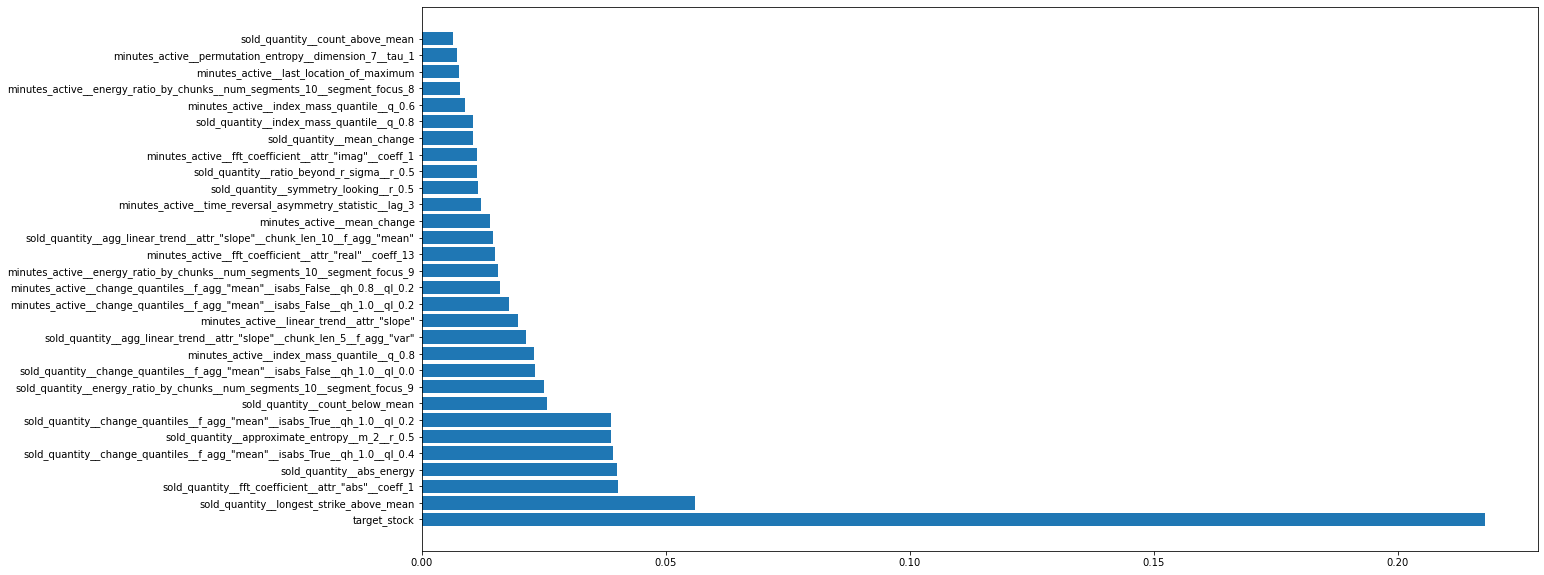

In [76]:
#feat_importance = model.tree_.compute_feature_importances(normalize=False)
print_feature_importance(model.feature_importances_, features)

In [68]:
text_representation = tree.export_text(model, feature_names=features + ['target_stock'])
print(text_representation)

|--- target_stock <= 2.50
|   |--- sold_quantity__energy_ratio_by_chunks__num_segments_10__segment_focus_9 <= 0.00
|   |   |--- minutes_active__energy_ratio_by_chunks__num_segments_10__segment_focus_9 <= 0.00
|   |   |   |--- sold_quantity__linear_trend__attr_"stderr" <= 0.06
|   |   |   |   |--- sold_quantity__c3__lag_2 <= 0.66
|   |   |   |   |   |--- current_price__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20) <= 838.35
|   |   |   |   |   |   |--- minutes_active__approximate_entropy__m_2__r_0.1 <= 0.22
|   |   |   |   |   |   |   |--- current_price__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) <= -26.62
|   |   |   |   |   |   |   |   |--- sold_quantity__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20) <= 0.12
|   |   |   |   |   |   |   |   |   |--- sold_quantity__cwt_coefficients__coeff_12__w_5__widths_(2, 5, 10, 20) <= 0.56
|   |   |   |   |   |   |   |   |   |   |--- class: 28
|   |   |   |   |   |   |   |   |   |--- sold_quantity__cwt_coefficients__coeff

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
start_time = time.time()
model = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=20, max_samples=0.6)
model.fit(X_train, y_train)
print("Model Training took:", str(time.time() - start_time), "seconds")
y_pred = model.predict_proba(X_val)
y_pred = (y_pred/y_pred.sum(axis=1)[:,None]).round(4)
rps(y_pred, np.eye(30)[y_val.astype(int)])

Model Training took: 197.3344967365265 seconds


4.040246786359968

In [85]:
preds = model.predict_proba(X_test)
preds = (preds/preds.sum(axis=1)[:,None]).round(4)
rps(preds, ground_truth)

4.040691946192526

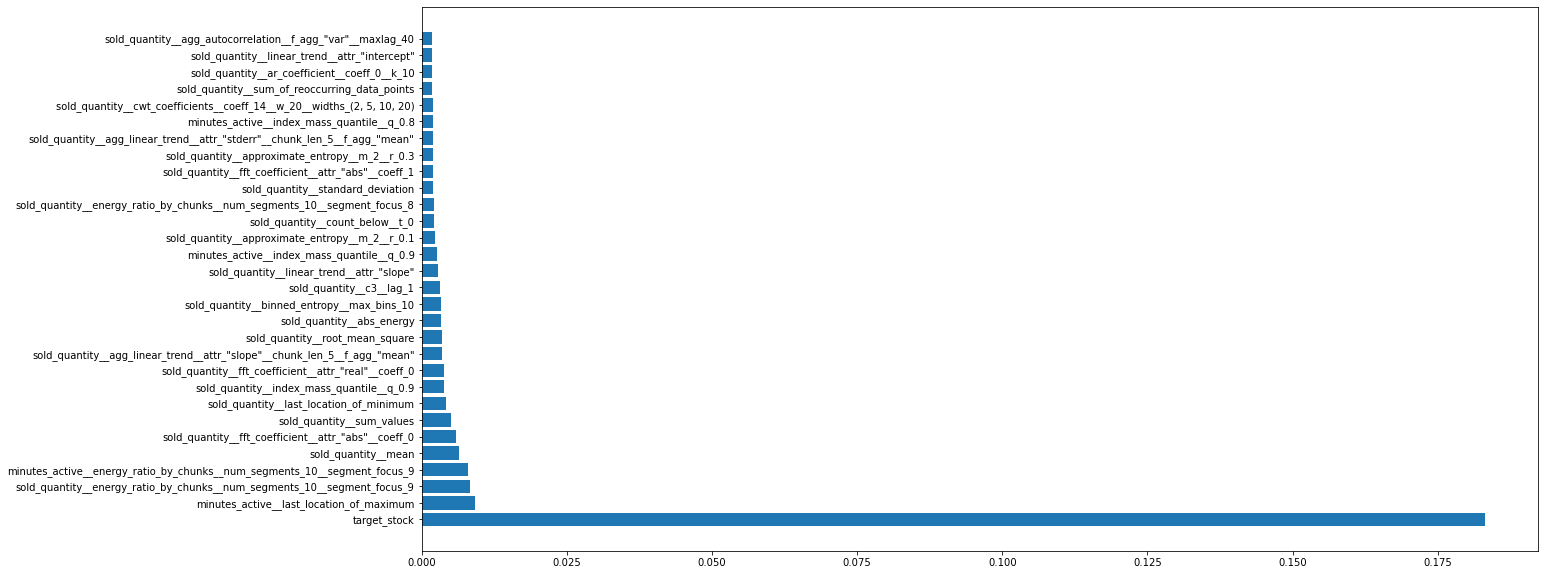

In [86]:
print_feature_importance(model.feature_importances_, features)

In [96]:
from xgboost import XGBClassifier
#model = MultiOutputRegressor(XGBRegressor(
#                         n_estimators=800, max_depth=2, learning_rate=0.01,
#                         random_state=0, tree_method='gpu_hist',
#                         gpu_id=3), n_jobs=14)
model = XGBClassifier(n_estimators=1000, max_depth=6, learning_rate=0.1,
                    random_state=0, tree_method='gpu_hist', objective='multi:softprob', num_class=30,
                    gpu_id=3)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)
y_pred = (y_pred/y_pred.sum(axis=1)[:,None]).round(4)
rps(y_pred, np.eye(30)[y_val.astype(int)])

[19:40:27] WARNING: /home/edugarcia/dependencies/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


3.9388136526870503

In [88]:
preds = model.predict_proba(X_test)
preds = (preds/preds.sum(axis=1)[:,None]).round(4)
rps(preds, ground_truth)

4.009161948050516

n_estimators=1000, max_depth=2, learning_rate=0.08, 38.77598546656583
model = XGBRegressor(n_estimators=1000, max_depth=2, learning_rate=0.2, 38.27539167059256
n_estimators=1000, max_depth=4, learning_rate=0.1, 37.546678641103945
n_estimators=1000, max_depth=6, learning_rate=0.1, 37.40878445231095

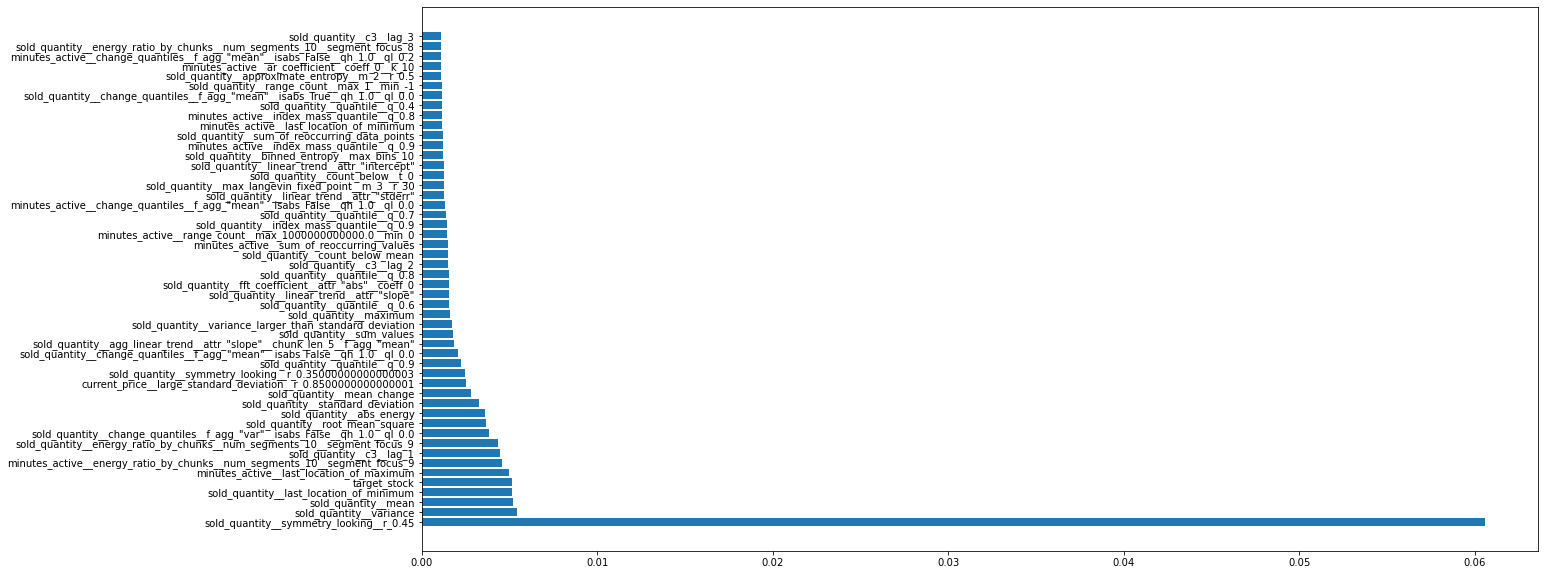

In [103]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
#features_importances = model.estimators_[-1].feature_importances_
features_importances = model.feature_importances_
sort = np.flip(np.argsort(features_importances))[0:50]
ax.barh(np.array(all_filtered_columns + ['target_stock'])[sort], features_importances[sort])
plt.show()

In [95]:
from skopt import gp_minimize

def tune(params):
    print('params', params)
    model = XGBClassifier(n_estimators=500, learning_rate=params[0],
                       max_depth=params[1],
                       subsample=params[2],
                       #colsample_bytree=params[3],
                       min_child_weight=params[3],
                       random_state=42, objective='multi:softprob', num_class=30,
                       tree_method='gpu_hist', gpu_id=3)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)
    y_pred = (y_pred/y_pred.sum(axis=1)[:,None]).round(4)
    return rps(y_pred, np.eye(30)[y_val.astype(int)])

space = [
         (1e-3, 2e-1, 'log-uniform'),
         (1, 10),
         #(0.05, 0.95),
         (0.05, 0.95),
         (1,300)]
res = gp_minimize(tune, space, random_state=42, verbose=1, acq_optimizer="lbfgs", n_jobs=10)

Iteration No: 1 started. Evaluating function at random point.
params [0.06805645222069413, 3, 0.7517219002454926, 179]
[19:37:51] WARNING: /home/edugarcia/dependencies/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [106]:
variables_to_train = np.flip(np.argsort(features_importances))[0:100]
model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                    random_state=0, tree_method='gpu_hist', objective='multi:softprob', num_class=30,
                    gpu_id=3)
model.fit(X[:, variables_to_train], y)
preds = model.predict_proba(X_test[:, variables_to_train])
preds = (preds/preds.sum(axis=1)[:,None]).round(4)
rps(preds, ground_truth)

[21:08:21] WARNING: /home/edugarcia/dependencies/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


3.983386705976322

In [ ]:
model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                    random_state=0, tree_method='gpu_hist', objective='multi:softprob', num_class=30,
                    gpu_id=3)
model.fit(X, y)
preds = model.predict_proba(X_test)
preds = (preds/preds.sum(axis=1)[:,None]).round(4)
rps(preds, ground_truth)

In [ ]:
def shift(arr, num, fill_value=0):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

def gaussian_kernel1d(sigma, length, order=0):
    """
    Computes a 1-D Gaussian convolution kernel.
    """
    if order < 0:
        raise ValueError('order must be non-negative')
    exponent_range = np.arange(order + 1)
    sigma2 = sigma * sigma
    x = np.arange(np.floor(-length/2), np.ceil(length/2))
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()
    return phi_x

In [ ]:
probabilities = np.zeros((len(df_test), 30))

normalized_preds = (preds.round()+0.5).astype(int)
for i in np.arange(2, 8, 0.1):
    gaussian_len = 30
    sigma = i
    #sigma = sigma if sigma > 0 else 1
    gaussian = gaussian_kernel1d(sigma, gaussian_len)
    gassian_possibilites = np.zeros((30, 30))
    gaussian_central_point = 15
    for j in range(30):
        target_day = j
        shift_amount = target_day-gaussian_central_point
        probs = shift(gaussian, shift_amount)
        probs = probs/probs.sum()
        gassian_possibilites[j] = probs.round(4)
    
    probabilities = gassian_possibilites[normalized_preds]

    print(sigma, rps(probabilities, ground_truth))

#
#Melhor sigma == 7.1 rps- 4.156727036526029
#

In [ ]:
normalized_preds

In [ ]:
0.5 + 0.4

In [ ]:
probabilities = np.zeros((len(df_test), 30))

#normalized_preds = (preds.round() + 1).astype(int)

gaussian_len = 30
gaussian_central_point = 15
sigma = 7.1

for j, pred in enumerate(preds):
    target_day = pred.round().astype(int)
    target_day = np.clip(target_day, 0, 29)
    #sigma = sigma if sigma > 0 else 1
    #sigma = np.abs(0.5 -(np.abs(target_day - pred))/0.5)*14
    gaussian = gaussian_kernel1d(sigma, gaussian_len)
    shift_amount = target_day-gaussian_central_point
    probs = shift(gaussian, shift_amount)
    probs[target_day+1:] = 0
    probs = probs/probs.sum()
    probabilities[j] = probs.round(4)

print(sigma, rps(probabilities, ground_truth))

In [ ]:
probabilities

In [ ]:
probs

In [ ]:
from scipy.stats import norm

def normal_probs(data):
    row, pred = data
    sku = row['sku']
    target_stock = row['target_stock']
    
    #sold_mean, sold_std = pred
    
    
    days_stockout = pred+1
    std_days = 7

    dist_model = norm(days_stockout,std_days)

    probalities = np.zeros(30)
    for i in range(1, 31):
        probalities[i-1] = (dist_model.cdf(i+1) - dist_model.cdf(i))

    if probalities.sum() == 0:
        probalities = np.ones(30) / 30

    probalities = (probalities/probalities.sum()).round(4)
    #probalities = saferound(probalities, places=4)
    return (sku, probalities)

predictions = np.zeros((len(df_test), 30))
i = 0
with Pool(100) as p:
    for data in tqdm(p.imap(normal_probs, zip(df_test.to_dict(orient='records'), preds)), total=len(df_test)):
        sku, probabilities = data
        predictions[i] = probabilities
        i += 1
        
from evaluate import rps
rps(predictions, ground_truth)

stds
5 - 4.262929225335388
7 - 4.198544959223248
10 - 4.3...
8 - 4.22
6 - 4.204762802167254

In [ ]:
from evaluate import rps
rps(predictions, ground_truth)

In [ ]:
from scipy.stats import norm

def normal_probs(data):
    row, preds = data
    sku = row['sku']
    target_stock = row['target_stock']
    
    sold_mean = preds.mean()
    sold_std = preds.std()
    
    c = preds.cumsum()  
    days_stockout = np.where(c>target_stock)[0]
    days_stockout = 30 if len(days_stockout) == 0 else days_stockout[0]+1
    
    std_days = (sold_std / sold_mean) * days_stockout

    dist_model = norm(days_stockout,std_days)

    probalities = np.zeros(30)
    for i in range(1, 31):
        probalities[i-1] = (dist_model.cdf(i+1) - dist_model.cdf(i))

    if probalities.sum() == 0:
        probalities = np.ones(30) / 30

    probalities = (probalities/probalities.sum()).round(4)
    #probalities = saferound(probalities, places=4)
    return (sku, probalities)

predictions = np.zeros((len(df_test), 30))
i = 0
with Pool(50) as p:
    for data in tqdm(p.imap(normal_probs, zip(df_test.to_dict(orient='records'), y_pred)), total=len(df_test)):
        sku, probabilities = data
        predictions[i] = probabilities
        i += 1